In [77]:
import csv 
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from swarm_sim import *

%matplotlib inline 

In [64]:
PATH = '..\\data\\swarm-50-sats-scenario\\coords_v1_if_LLO-'
NB_NODES = 50
DURATION = 8641 # Number of data rows, not time!
REVOLUTION = 1800 # Number of data rows
CONNECTION_RANGE = 30 # km

row_metadata_end = 6
row_data_start = 7

In [18]:
metadata = {}
satellites = {}

with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df_metadata = pd.read_csv(PATH+str(i)+'.csv', skiprows = lambda x: x>row_metadata_end)
        metadata[i] = df_metadata
        df_data = pd.read_csv(PATH+str(i)+'.csv', skiprows= lambda x: x<row_data_start, header=0)
        satellites[i] = df_data
        pbar.update(1)
        
satellites[0].head()

Extracting data:   0%|          | 0/50 [00:00<?, ?it/s]

Extracting data: 100%|██████████| 50/50 [00:02<00:00, 23.41it/s]


,Time[EpSec],xF[km],yF[km],zF[km],xI[km],yI[km],zI[km]
0,0.0,997.833970,-1128.770350,-1576.120871,-398.587611,-729.991953,-2015.487980
1,10.0,1002.088984,-1141.149732,-1564.489841,-407.058250,-743.753719,-2008.772633
2,20.0,1006.295944,-1153.475366,-1552.784813,-415.509636,-757.480307,-2001.962275
3,30.0,1010.454657,-1165.746669,-1541.006346,-423.941371,-771.171070,-1995.057233
4,40.0,1014.564936,-1177.963066,-1529.155006,-432.353058,-784.825365,-1988.057848


In [26]:
sat = satellites[0]
sat.shape[0] # Number of data rows

8641

In [29]:
swarm_data = {} # Dict{timestamp: Swarm}

with tqdm(total=DURATION, desc='Converting to Swarm') as pbar:
    for t in range(DURATION):
        swarm_data[t] = Swarm(connection_range=30,
                    nodes = [Node(id, sat['xF[km]'].iloc[t], sat['yF[km]'].iloc[t], sat['zF[km]'].iloc[t]) for id,sat in satellites.items()]
                    )
        pbar.update(1)

swarm = swarm_data[0]
print(swarm)
print(swarm.nodes[0])


Converting to Swarm: 100%|██████████| 8641/8641 [00:15<00:00, 560.90it/s]

Swarm of 50 node(s), connection range: 30
Node ID 0 (997.8339696875933,-1128.7703496684833,-1576.1208708760105) has 0 neighbor(s)	Group: -1


In [62]:
def plot_nodes(swarm, n_color='blue'):
    """
    Function to create a 3D-plot of the swarm at a given timestamp. 

    Args:
        n_color (str, optional) : Nodes color. Defaults to 'blue'.
    """
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    x_data = [node.x for node in swarm.nodes]
    y_data = [node.y for node in swarm.nodes]
    z_data = [node.z for node in swarm.nodes]
    ax.scatter(x_data, y_data, z_data, c=n_color, s=50)
    
    
def plot_trajectory(data, sat_id, stop=DURATION, moon=True):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    if moon:
        ax.scatter([0], [0], [0], c='gray', edgecolors='black', s=1000)
    x_data = [swarm.nodes[sat_id].x for t,swarm in data.items() if t<stop]
    y_data = [swarm.nodes[sat_id].y for t,swarm in data.items() if t<stop]
    z_data = [swarm.nodes[sat_id].z for t,swarm in data.items() if t<stop]
    ax.scatter(x_data, y_data, z_data, c='blue', s=50)
    
    
    

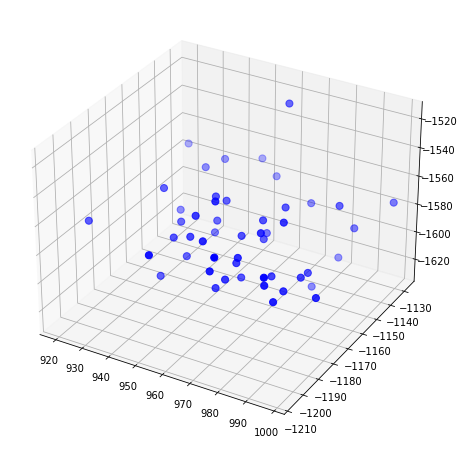

In [42]:
plot_nodes(swarm_data[0])

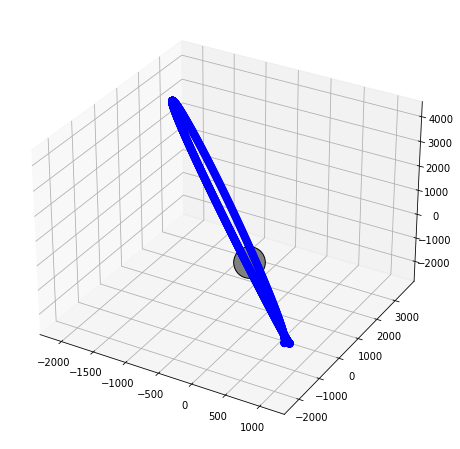

In [63]:
plot_trajectory(swarm_data, sat_id=48, stop=1800)

In [67]:
distances = {}

with tqdm(total=REVOLUTION, desc='Distance matrix') as pbar:
    for t in range(REVOLUTION):
        distances[t] = swarm_data[t].distance_matrix()
        pbar.update(1)

Distance matrix: 100%|██████████| 1800/1800 [00:02<00:00, 788.09it/s]


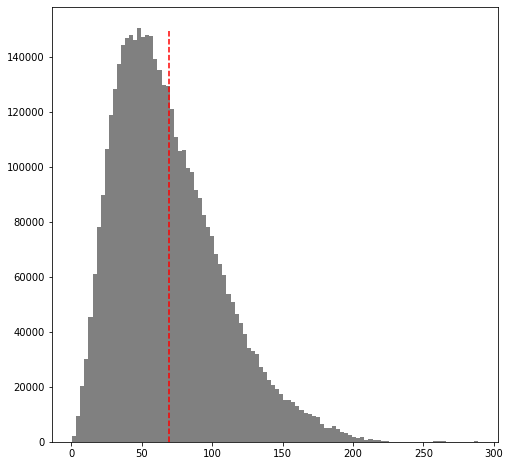

In [73]:
distance_data = [e for t_dist in distances.values() for dist in t_dist for e in dist]
avg = np.mean(distance_data)

plt.figure(figsize=(8,8))
plt.hist(distance_data, bins=100, color='gray')
plt.vlines(avg, ymin=0, ymax=150000, ls='--', colors='red')

In [65]:
with tqdm(total=REVOLUTION, desc='Neighbor matrix') as pbar:
    for t in range(REVOLUTION):
        neighbor_matrix = swarm_data[t].neighbor_matrix()
        pbar.update(1)

Neighbor matrix: 100%|██████████| 1800/1800 [00:05<00:00, 305.20it/s]


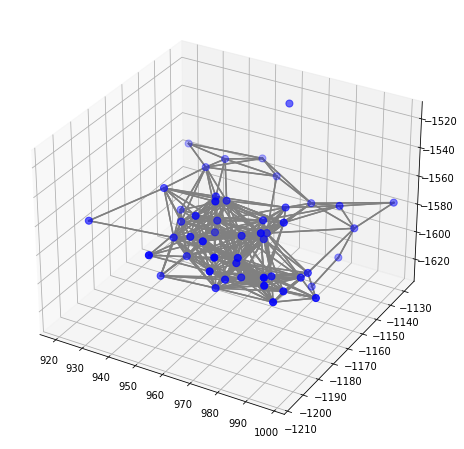

In [66]:
swarm_data[0].plot_edges()

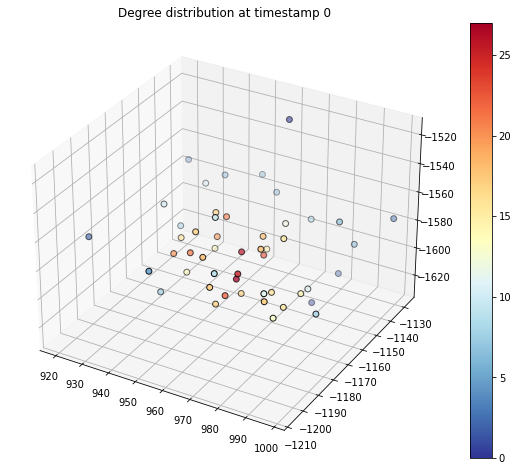

In [75]:
# Display the node degrees

def colormap(swarm, val, title=None, vmin=0, vmax=None):
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d')
    x_data = [node.x for node in swarm.nodes]
    y_data = [node.y for node in swarm.nodes]
    z_data = [node.z for node in swarm.nodes]
    if not vmax:
        vmax = max(val)
    
    cm = plt.cm.get_cmap('RdYlBu_r')
    sc = ax.scatter(x_data, y_data, z_data, c=val, s=35, edgecolors='black', cmap=cm, vmin=vmin, vmax=vmax)
    plt.colorbar(sc)
    ax.set_title(title)
    
    
t = 0
swarm = swarm_data[t]
colormap(swarm, val=swarm.degree(), title='Degree distribution at timestamp '+str(t))

Text(0, 0.5, 'Average degree')

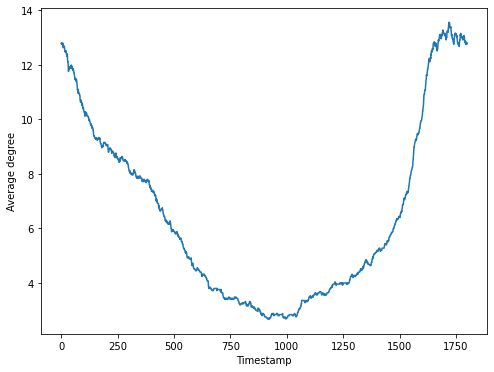

In [76]:
degrees = [np.mean(swarm.degree()) for t,swarm in swarm_data.items() if t<REVOLUTION]

plt.figure(figsize=(8,6))
plt.plot(degrees)
plt.xlabel('Timestamp')
plt.ylabel('Average degree')

In [121]:
print(np.mean(degrees))
print(np.mean(swarm_data[1000].degree()))
print(np.mean(swarm_data[500].degree()))
print(np.mean(swarm_data[1712].degree()))

6.5277111111111115
2.72
5.88
13.24


In [122]:
t = 500
swarm = swarm_data[t]
graph = swarm.swarm_to_nxgraph()
nx.number_connected_components(graph)

4

In [85]:
t = 1511
swarm = swarm_data[t]
graph = swarm.swarm_to_nxgraph()

nx.betweenness_centrality(graph)

{0: 0.25,
 1: 0.031009290558603724,
 2: 0.1140086288795148,
 3: 0.1608272817449469,
 4: 0.0007261634812655221,
 5: 0.00921201814058957,
 6: 0.005853809113073345,
 7: 0.10880754766330668,
 8: 0.04736652338714453,
 9: 0.0,
 10: 0.010769722021442761,
 11: 0.0,
 12: 0.07945123438647723,
 13: 0.006231613906246254,
 14: 0.08904509149091532,
 15: 0.0007261634812655221,
 16: 0.008570082816777418,
 17: 0.030552933015776895,
 18: 0.0,
 19: 0.1046166129067785,
 20: 0.002842894636487074,
 21: 0.016247310890168034,
 22: 0.020784126792518207,
 23: 0.022876284853483378,
 24: 0.1173469387755102,
 25: 0.2193877551020408,
 26: 0.15306122448979592,
 27: 0.02835767419756026,
 28: 0.07993197278911564,
 29: 0.08213165712724475,
 30: 0.03810804544922042,
 31: 0.11047258379847663,
 32: 0.06327433574880845,
 33: 0.0402698355913499,
 34: 0.017461295508975305,
 35: 0.006231613906246254,
 36: 0.04081632653061224,
 37: 0.03550016698880402,
 38: 0.04381751387542223,
 39: 0.025744053943066024,
 40: 0.040062105314624

Text(0, 0.5, '# Connected components')

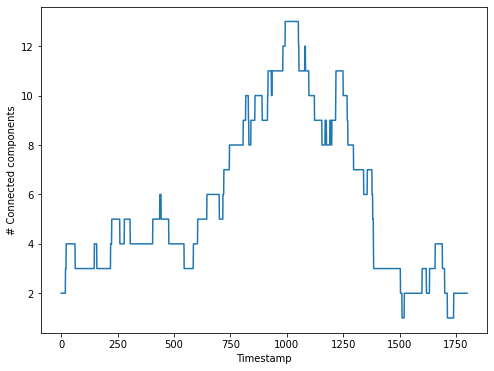

In [79]:
graphs = [sw.swarm_to_nxgraph() for t,sw in swarm_data.items() if t<REVOLUTION]
cc = [nx.number_connected_components(g) for g in graphs]

plt.figure(figsize=(8,6))
plt.plot(cc)
plt.xlabel('Timestamp')
plt.ylabel('# Connected components')

In [115]:
[i for i, e in enumerate(cc) if e == 1]

[1511,
 1512,
 1513,
 1514,
 1515,
 1516,
 1517,
 1518,
 1519,
 1520,
 1712,
 1713,
 1714,
 1715,
 1716,
 1717,
 1718,
 1719,
 1720,
 1721,
 1722,
 1723,
 1724,
 1725,
 1726,
 1727,
 1728,
 1729,
 1730,
 1731,
 1732,
 1733,
 1734,
 1735,
 1736,
 1737,
 1738,
 1739]

In [123]:
LOWEST_TSP = 1000 # 13 connected components, avg_deg = 2.7
AVG_TSP = 500 # 4 connected components, avg_deg = 5.9
CONNECTED_TSP = 1712 # 1 connected component, avg_deg = 13.2

In [127]:
t = CONNECTED_TSP
df_topo = pd.DataFrame(
    data=[[sat['xF[km]'].iloc[t], sat['yF[km]'].iloc[t], sat['zF[km]'].iloc[t]] for sat in satellites.values()],
    columns=['x','y','z']
)
df_topo['sat_id'] = list(satellites.keys())
df_topo = df_topo.set_index('sat_id', drop=True)

df_topo.to_csv('../data/Topologies/topology_connected_sat50.csv', sep=',')

In [95]:
def theoretical_cost(nb_groups, nmax=NB_NODES):
    group_size = nmax/nb_groups
    total_intra = nb_groups * group_size*(group_size-1)
    total_inter = nb_groups * (nb_groups-1)
    return total_inter+total_intra

Text(0.5, 1.0, 'Number of transmissions for a 50-node graph division')

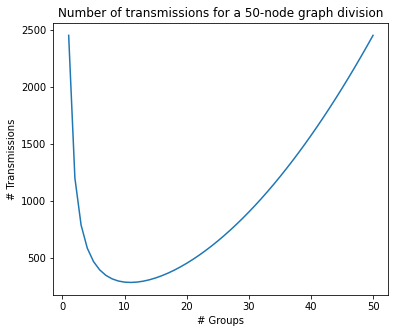

In [99]:
nmax = 50
nb_groups = list(range(1,nmax+1))


plt.figure(figsize=(6,5))
plt.plot(nb_groups, [theoretical_cost(nb, nmax) for nb in nb_groups])
plt.xlabel('# Groups')
plt.ylabel('# Transmissions')
plt.title('Number of transmissions for a '+str(nmax)+'-node graph division')